In [1]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc

plt.rc("font", family = "Malgun Gothic") #matplot은 영어만 지원하므로 한글폰트를 지정해줘야한다.

In [2]:
conn = pymysql.connect(
    host = "127.0.0.1",
    user = "root",
    password = , # 비밀번호 지정
    database =  # 데이터셋 지정
)

In [41]:
# conn.close()

### **지역별로 상품을 구입한 인원을 파악하기**

In [4]:
order_count_sql = """
SELECT customer_state, count(*) AS order_count 
FROM order_customers
GROUP BY customer_state;
"""

In [6]:
order_count_df = pd.read_sql(order_count_sql, conn)

C:\Users\ysh10\AppData\Local\Temp\ipykernel_16756\3388418540.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_count_df = pd.read_sql(order_count_sql, conn)


In [35]:
state_sql = """
SELECT distinct customer_state
FROM order_customers;
"""

In [36]:
state_df = pd.read_sql(state_sql, conn)

C:\Users\ysh10\AppData\Local\Temp\ipykernel_16756\829668915.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  state_df = pd.read_sql(state_sql, conn)


In [40]:
state_df

,customer_state
0,SP
1,MG
2,ES
3,RJ
4,RS
5,BA
6,CE
7,PR
8,MS
9,PB


| region | state |
| --- | --- |
| Southeast | SP, RJ, ES, MG |
| South | PR, SC, RS |
| Midwest | DF, GO, MT, MS |
| North | PA, AP, AM, RR, AC, RO, TO |
| Northeast | BA, CE, PB, RN, PE, PI, MA, SE, AL |

In [7]:
def assign_region(state):
    if state in ["SP", "RJ", "ES", "MG"]:
        return "Southeast"
    elif state in ["PR", "SC", "RS"]:
        return "South"
    elif state in ["DF", "GO", "MT", "MS"]:
        return "Midwest"
    elif state in ["PA", "AP", "AM", "RR", "AC", "RO", "TO"]:
        return "North"
    else:
        return "Northeast"

In [8]:
#result_df에다가 region칼럼을 만들고 데이터를 대입
order_count_df["region"] = order_count_df["customer_state"].apply(assign_region)

In [9]:
#customer_state를 index로 설정
order_count_df.set_index("customer_state", inplace=True)

In [10]:
#result_df를 region기준으로 오름차순
order_count_df.sort_values(by="region", ascending=False)

,order_count,region
customer_state,,
RJ,12852,Southeast
SP,41746,Southeast
ES,2033,Southeast
MG,11635,Southeast
PR,5045,South
SC,3637,South
RS,5466,South
AL,413,Northeast
PI,495,Northeast


In [11]:
#region칼럼으로 groupby하고 region별로 order_count를 더해주기 -> order_count의 합계별로 오름차순하기 -> index숨기기
region_order_df = order_count_df.groupby("region")["order_count"].sum().reset_index().sort_values(by="order_count")
region_order_df.style.hide_index()

C:\Users\ysh10\AppData\Local\Temp\ipykernel_16756\2832175310.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  region_order_df.style.hide_index()


region,order_count
North,1851
Midwest,5782
Northeast,9394
South,14148
Southeast,68266


### **카테고리별 주문한 상품의 개수구하기**

In [12]:
category_sql = """
WITH product_name AS(
    SELECT 
        product_id, products.product_category_name, 
        COALESCE(cnt.product_category_name_english, products.product_category_name) AS product_category_name_english
    FROM 
        products LEFT JOIN category_name_translation AS cnt
    ON 
        products.product_category_name = cnt.product_category_name
)
SELECT 
    product_category_name_english, COUNT(order_id) AS category_count
FROM 
    order_items LEFT JOIN product_name
ON 
    order_items.product_id = product_name.product_id
GROUP BY 
    product_category_name, product_category_name_english;
"""

In [14]:
category_df = pd.read_sql(category_sql, conn)

C:\Users\ysh10\AppData\Local\Temp\ipykernel_16756\3708308417.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  category_df = pd.read_sql(category_sql, conn)


In [15]:
category_df

,product_category_name_english,category_count
0,None,1603
1,agro_industry_and_commerce,212
2,food,510
3,food_drink,278
4,art,209
...,...,...
69,signaling_and_security,199
70,tablets_printing_image,83
71,telephony,4545
72,fixed_telephony,264


In [16]:
category_df = category_df.fillna("No Name")
category_df.set_index("product_category_name_english", inplace=True)
top_category_df = category_df.sort_values(by="category_count", ascending=False).head(10)

In [17]:
top_category_df

,category_count
product_category_name_english,
bed_bath_table,11115
health_beauty,9670
sports_leisure,8641
furniture_decor,8334
computers_accessories,7827
housewares,6964
watches_gifts,5991
telephony,4545
garden_tools,4347


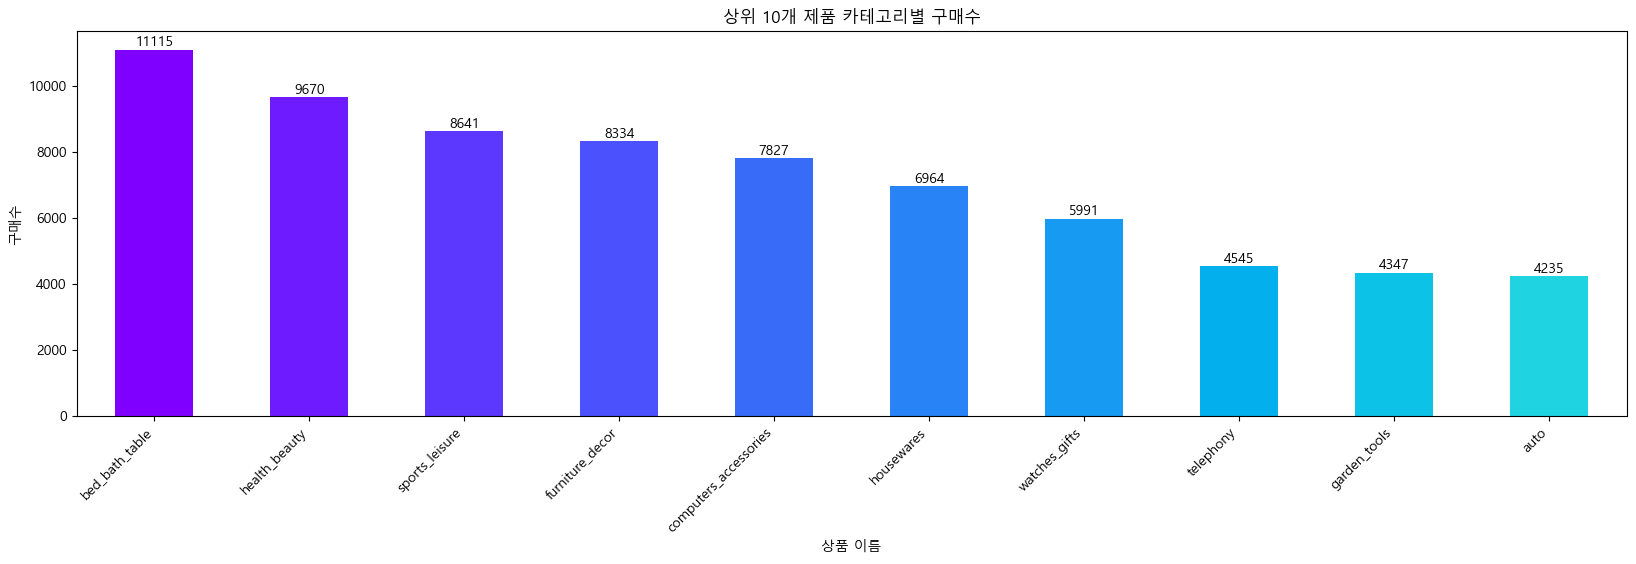

In [18]:
colors = plt.get_cmap("rainbow", 30)(np.linspace(0, 1, 30))
ax=top_category_df["category_count"].plot(
    kind="bar",
    figsize=(20, 5),
    color=colors,
    title="상위 10개 제품 카테고리별 구매수" 
)

for p in ax.patches:
    ax.annotate(
        str(p.get_height()), 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha="center", 
        va="center", 
        xytext=(0, 5), 
        textcoords="offset points", 
        fontsize=10,
        color="black"
    )

plt.xlabel("상품 이름")
plt.ylabel("구매수")
plt.xticks(rotation=45, ha="right")
plt.show()

In [19]:
category_df["category_count"].sum()

112650

### **지역별 구매한 상품별 개수**

In [20]:
region_cateogry_sql = """
WITH customers_info AS (
    SELECT 
        order_id, order_status, order_customers.customer_id, customer_state
    FROM 
        orders INNER JOIN order_customers
    ON 
        orders.customer_id = order_customers.customer_id
),
order_products  AS (
    SELECT 
        ci.order_id, order_status, product_id, customer_state
    FROM 
        order_items AS oi LEFT JOIN customers_info AS ci
    ON 
        ci.order_id = oi.order_id
),
order_name AS (
    SELECT 
        order_id, order_status, op.product_id, products.product_category_name, 
        COALESCE(cnt.product_category_name_english, products.product_category_name) AS product_category_name_english,customer_state
    FROM 
        order_products AS op 
    LEFT JOIN 
        products ON op.product_id = products.product_id
    LEFT JOIN 
        category_name_translation cnt ON products.product_category_name = cnt.product_category_name
)

SELECT 
    customer_state, product_category_name_english, COUNT(order_id) AS product_count
FROM 
    order_name
GROUP BY 
    customer_state, product_category_name_english
ORDER BY 
    customer_state, product_count DESC;
"""

In [22]:
region_category_df = pd.read_sql(region_cateogry_sql, conn)

C:\Users\ysh10\AppData\Local\Temp\ipykernel_16756\1770497380.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  region_category_df = pd.read_sql(region_cateogry_sql, conn)


In [23]:
# DataFrame의 모든 NaN 값 찾기
nan_df = region_category_df.isna()

# 특정 열에서 NaN 값 찾기
nan_column = region_category_df["product_category_name_english"].isna()

# NaN 값이 있는 행만 선택하기
nan_rows = region_category_df[region_category_df.isna().any(axis=1)]
nan_rows

,customer_state,product_category_name_english,product_count
18,AC,None,2
49,AL,None,4
89,AM,None,2
149,BA,None,60
213,CE,None,18
265,DF,None,33
329,ES,None,18
381,GO,None,53
449,MA,None,11
498,MG,None,181


In [24]:
region_category_df = region_category_df.fillna("No Name")

In [26]:
#지역별로 상품별 구입 개수를 top5만 표현
# region_category_top_df = region_category_count_df.groupby(["customer_state"]).head(5)
# region_category_top_df

In [27]:
region_category_df["region"] = region_category_df["customer_state"].apply(assign_region)
region_category_df = region_category_df.set_index("customer_state")

In [28]:
region_category_df

,product_category_name_english,product_count,region
customer_state,,,
AC,furniture_decor,12,North
AC,computers_accessories,9,North
AC,sports_leisure,9,North
AC,health_beauty,7,North
AC,telephony,5,North
...,...,...,...
TO,small_appliances_home_oven_and_coffee,1,North
TO,moveis_cozinha_area_de_servico_jantar_e_jardi,1,North
TO,fashion_shoes,1,North


In [29]:
# region_category_top10_df = region_category_count_df.sort_values(by=["region", "product_count"], ascending=[True, False]).groupby("region").head(10)
# region_category_top10_df

In [30]:
region_category_df = region_category_df.groupby(["region", "product_category_name_english"])["product_count"].sum().reset_index()

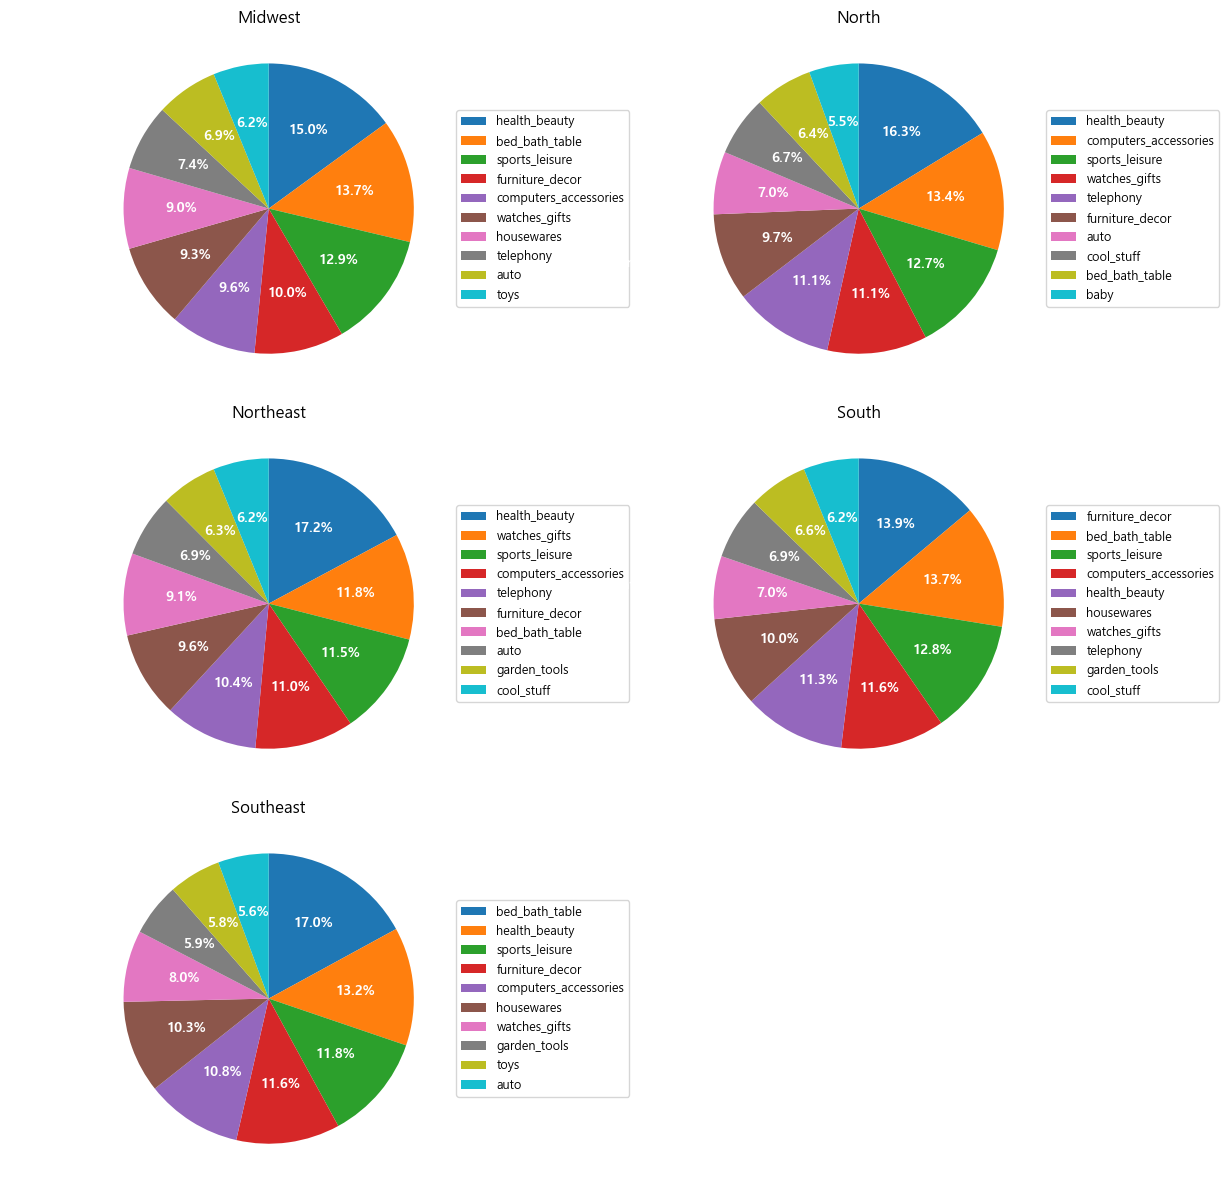

In [50]:
regions = region_category_df["region"].unique() # "region" 열의 유일한 값 가져오기

# 3행 2열의 subplot을 만듭니다.
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 전체 figure 사이즈 조정

# Flatten the 3x2 axes array to easily iterate
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = region_category_df[region_category_df["region"] == region]
    top_category = region_df.sort_values(by="product_count", ascending=False).head(10) # 내림차순해서 상위 10개의 product만 가져오기

    axes[i].pie(
        top_category["product_count"], 
        labels=top_category["product_category_name_english"],
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False # 그래프를 시계방향으로
    )
    
    axes[i].legend(
        top_category["product_category_name_english"], 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )
    axes[i].set_title(f"{region}", fontsize=12, pad=3)
    plt.setp(axes[i].texts, size=10, weight="bold", color="white")

# 마지막 빈 subplot이 있으면 숨기기
if len(regions) < 6:
    for j in range(len(regions), 6):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()